In [1]:
from tensorflow.keras.applications import VGG16

# 다른 pretrainde network 도 적용해보기

model_base = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150,150,3)) 
# weights : 여러개의 입력데이터셋에 대해서 어떤 트레이닝 데이터셋을 이용한 VGG16인지 명시해줘야함.
# include_top : conv와 pool과 DNN까지 포함할 것인지 True, False로 명시 
# input_shape : input 데이터셋의 형태 

model_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [4]:
# 개와 고양이 training data set에 대한 feature map을 추출하기

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './data/cat_dog_full'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
# ImageDataGenrator을 사용할 때 데이터를 어떤 폴더에서 가져오는지 명시
# os는 경로를 만들어주기 위함

datagen = ImageDataGenerator(rescale=1/255)
batch_size=20
# RGB 값이 0 ~ 255 사이 값을 255로 나눠서 0~1사이 값으로 scaling 해주기
# batch size 정해서 20개씩 가져오기

def extract_feature(directory, sample_count):
# directory : 특정 폴더에 가서 이미지 가져오기 위해
# sample_count : 이미지 개수
  
    features = np.zeros(shape=(sample_count, 4,4, 512))
  # np.zeros 함수를 통해 우선 형태만 만들어 0으로 채워주고 이후 데이터 붙여주기
  # sample_count = 이미지 개수
  # VGG16에서 최종적으로 나오는 (None, 4, 4, 512)에서 shape 맞춰주기
    labels = np.zeros(shape=(sample_count,))
    
    generator = datagen.flow_from_directory(
      directory,
      target_size = (150,150),
      batch_size = batch_size,
      class_mode = 'binary'
  )
    
    i = 0
    
    for x_data_batch, t_data_batch in generator:
        feature_batch = model_base.predict(x_data_batch)
        features[i*batch_size:(i+1)*batch_size] = feature_batch
        labels[i*batch_size:(i+1)*batch_size] = t_data_batch
        
        i += 1
        
        if i * batch_size >= sample_count:
            break
  
    return features, labels

train_features, train_labels = extract_feature(train_dir, 2000)
validation_features, validation_labels = extract_feature(validation_dir, 1000)






Found 14000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000,4*4*512))
validation_features = np.reshape(validation_features, (1000,4*4*512))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout # flatten 도 dense로 처리
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(256,
                activation='relu',
                input_shape=(4*4*512,)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features,
                    train_labels,
                    epochs=30,
                    batch_size=64,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
32/32 [==============================] - 1s 22ms/step - loss: 0.6056 - accuracy: 0.6514 - val_loss: 0.3548 - val_accuracy: 0.8490
Epoch 2/30
32/32 [==============================] - 0s 6ms/step - loss: 0.3599 - accuracy: 0.8393 - val_loss: 0.3176 - val_accuracy: 0.8640
Epoch 3/30
32/32 [==============================] - 0s 6ms/step - loss: 0.3063 - accuracy: 0.8625 - val_loss: 0.2956 - val_accuracy: 0.8760
Epoch 4/30
32/32 [==============================] - 0s 5ms/step - loss: 0.2434 - accuracy: 0.9087 - val_loss: 0.3043 - val_accuracy: 0.8660
Epoch 5/30
32/32 [==============================] - 0s 5ms/step - loss: 0.2266 - accuracy: 0.9022 - val_loss: 0.2806 - val_accuracy: 0.8810
Epoch 6/30
32/32 [==============================] - 0s 5ms/step - loss: 0.1890 - accuracy: 0.9314 - val_loss: 0.2749 - val_accuracy: 0.8820
Epoch 7/30
32/32 [==============================] - 0s 5ms/step - loss: 0.1706 - accuracy: 0.9383 - val_loss: 0.2827 - val_accuracy: 0.8790
Epoch 8/30
32/32 [=

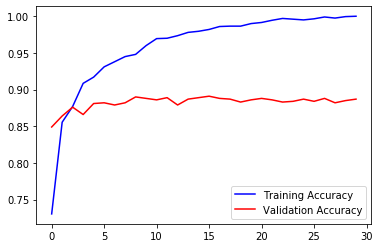

In [6]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

plt.plot(train_acc, color='b', label='Training Accuracy')
plt.plot(val_acc, color='r', label='Validation Accuracy')

# plt.plot(train_loss, color='b', label='Training Loss')
# plt.plot(val_loss, color='r', label='Validation Loss')

plt.legend()
plt.show()


